In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import joblib

layer1 = 2
layer2 = 8
data = pd.read_csv(f'Training_data/MLIN_{layer1}_{layer2}_mid.csv')
data_int=data.iloc[:,:]

data_int_10=np.tile(data_int, (30, 1)) #串聯10倍長度
mean,var = 0,0.0001
noise = np.random.normal(mean, var, data_int_10.shape[0]) #並加入noise
noise = np.random.normal(mean, var, data_int_10.shape) #並加入noise
print(noise.shape)
data_noise_10 = data_int_10+noise*0.00001 #嘗試在不同大小的noise
X = data_noise_10[:, :2]
y = data_noise_10[:, 2:8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)



(51030, 7)
(40824, 2) (10206, 2) (40824, 5) (10206, 5)


In [17]:
xgb = XGBRegressor(objective='reg:squarederror',
                   seed=42)
param_grid = {
    'estimator__learning_rate': [0.05,0.75,0.1],
    'estimator__n_estimators': [800,900,1000],
    'estimator__max_depth': [8,9,10],
       'estimator__min_child_weight': [5 , 7],
       'estimator__gamma': [0.0,0.1],
       'estimator__subsample': [0.8, 0.9 , 1]
}
 
multi_output_model = MultiOutputRegressor(xgb)

grid_search = GridSearchCV(estimator=multi_output_model,
                           param_grid=param_grid,
                           cv=2,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

best_xgb_model = XGBRegressor(objective='reg:squarederror',
                              learning_rate=best_params['estimator__learning_rate'],
                              n_estimators=best_params['estimator__n_estimators'],
                              max_depth=best_params['estimator__max_depth'],
                              min_child_weight=best_params['estimator__min_child_weight'],
                              gamma=best_params['estimator__gamma'],
                              subsample=best_params['estimator__subsample'],
                              colsample_bytree=0.8,
                              reg_alpha=0,
                              reg_lambda=1,
                              seed=42)
best_multi_output_model = MultiOutputRegressor(best_xgb_model)

best_multi_output_model.fit(X_train, y_train)

y_pred = best_multi_output_model.predict(X_test)
# 
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print(f'R² scores for each output: {r2_scores}')

Fitting 2 folds for each of 324 candidates, totalling 648 fits


C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


Best parameters found: {'estimator__gamma': 0.0, 'estimator__learning_rate': 0.75, 'estimator__max_depth': 10, 'estimator__min_child_weight': 5, 'estimator__n_estimators': 1000, 'estimator__subsample': 0.8}


C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


R² scores for each output: [0.94297838 0.64363294 0.99999347 0.99968942 0.99861132]


In [18]:
RMSE=np.sqrt(((y_test-y_pred) ** 2)/(y_pred.size))
print('RMSE [S11,S21,beta,alpha,Zo] : ')ㄇ
NRMSE=RMSE/abs(np.mean(y_pred, axis=0))
print('NRMSE [S11,S21,beta,alpha,Zo] :')
print(NRMSE)
error_df = pd.DataFrame(NRMSE, columns=['S11_error', 'S21_error', 'beta_error', 'alpha_error', 'Zo_error'])

# 保存為 CSV 檔案
error_df.to_csv(f'MLIN_nrsme_{layer1}_{layer2}_mid.csv', index=False)

RMSE [S11,S21,beta,alpha,Zo] : 
[[9.28763317e-03 8.74576605e-04 1.71908207e-05 5.91749707e-07
  5.86407412e-05]
 [1.56675254e-02 8.62609425e-04 1.85702832e-04 1.31552866e-06
  1.14431319e-03]
 [1.21509983e-02 2.63524541e-03 6.85354699e-04 2.03502901e-05
  3.92651855e-03]
 ...
 [9.03526721e-03 3.13889536e-03 3.08738106e-04 4.73796373e-06
  3.01196347e-04]
 [1.29273419e-02 1.69992420e-04 4.08115648e-04 6.33786657e-06
  4.52616336e-04]
 [4.30737561e-03 1.58235363e-03 2.71652512e-05 2.10240459e-06
  6.18441622e-04]]
NRMSE [S11,S21,beta,alpha,Zo] :
[[3.36714982e-04 8.58425599e-04 1.14629595e-08 1.78851133e-07
  5.17264070e-07]
 [5.68012369e-04 8.46679420e-04 1.23827947e-07 3.97606942e-07
  1.00938714e-05]
 [4.40523769e-04 2.58657973e-03 4.56999308e-07 6.15069582e-06
  3.46354245e-05]
 ...
 [3.27565676e-04 3.08092867e-03 2.05868729e-07 1.43200778e-06
  2.65682262e-06]
 [4.68669425e-04 1.66853131e-04 2.72134369e-07 1.91556431e-06
  3.99248310e-06]
 [1.56160119e-04 1.55313194e-03 1.81139795e-0

In [4]:
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['estimator__learning_rate'],
    n_estimators=best_params['estimator__n_estimators'],
    max_depth=best_params['estimator__max_depth'],
     min_child_weight=best_params['estimator__min_child_weight'],
     gamma=best_params['estimator__gamma'],
     subsample=best_params['estimator__subsample'],
    seed=42
)


data = pd.read_csv('only_freq.csv')##val_input.csv
X_val = data.iloc[:,:]
# 
best_multi_output_model = MultiOutputRegressor(best_xgb_model)

best_multi_output_model.fit(X_train, y_train)

y_pred_val = best_multi_output_model.predict(X_val)

joblib.dump(best_multi_output_model, f'model_MLIN_{layer1}_{layer2}_mid.joblib')


C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


['model_MLIN_3_6_mid.joblib']

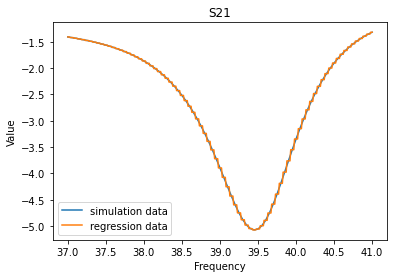

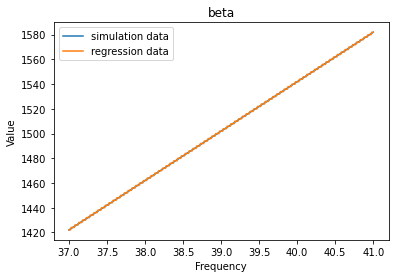

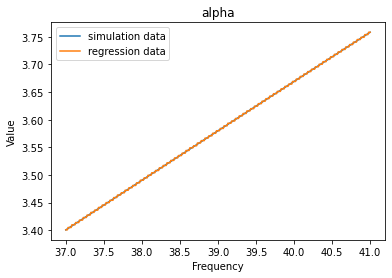

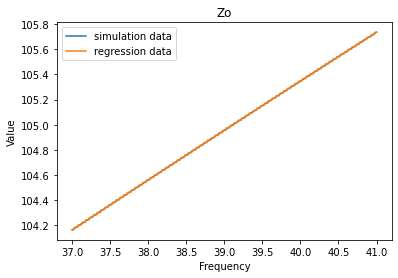

In [5]:
import matplotlib.pyplot as plt

k = 0
head_81=k*81
head_401=k*401

data_int = np.array(data_int)
freq_81=np.arange(37, 41.05, 0.05)
freq_401=np.arange(37, 41.01, 0.01)
plt.plot(freq_81, data_int[head_81:head_81+81, 3], label='simulation data')
plt.plot(freq_401, y_pred_val[head_401:head_401+401, 1], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('S21')
plt.legend()
plt.show()

#beta
plt.plot(freq_81, data_int[head_81:head_81+81, 4], label='simulation data')
plt.plot(freq_401, y_pred_val[head_401:head_401+401, 2], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('beta')
plt.legend()
plt.show()

#alpha
plt.plot(freq_81, data_int[head_81:head_81+81, 5], label='simulation data')
plt.plot(freq_401, y_pred_val[head_401:head_401+401, 3], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('alpha')
plt.legend()
plt.show()

#Zo
plt.plot(freq_81, data_int[head_81:head_81+81, 6], label='simulation data')
plt.plot(freq_401, y_pred_val[head_401:head_401+401, 4], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Zo')
plt.legend()
plt.show()

(401, 5)


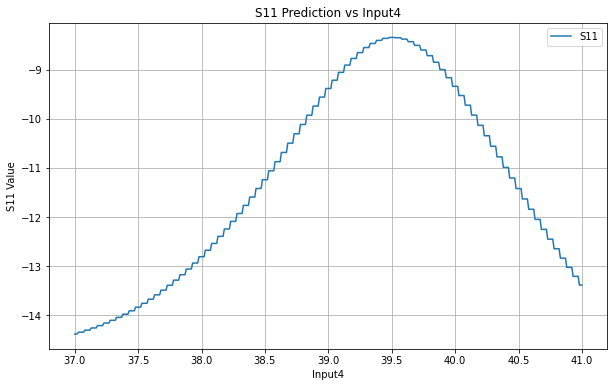

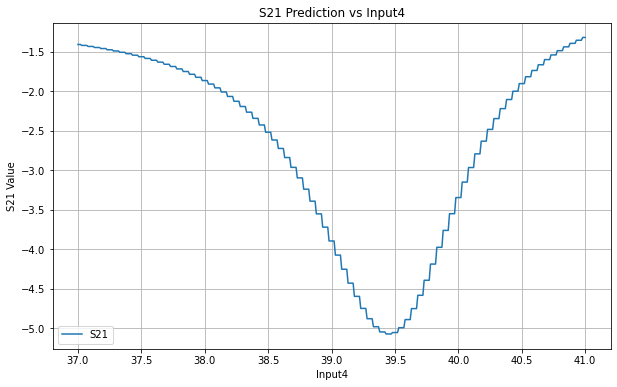

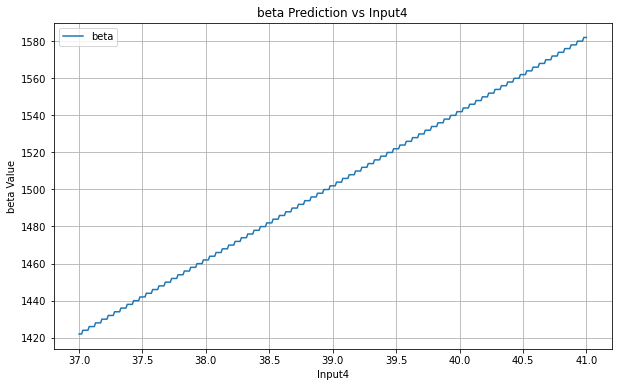

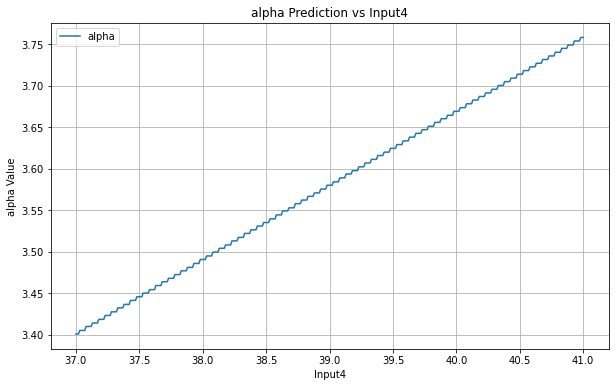

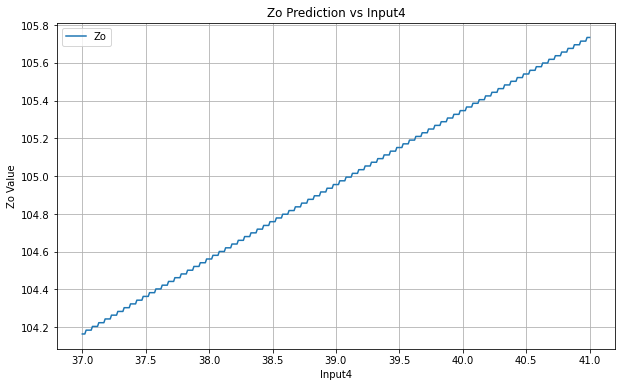

In [6]:
loaded_multi_output_model = joblib.load(f'model_MLIN_{layer1}_{layer2}_mid.joblib')
input1 = np.full(401,0.5)  # 401個0.1
# input2 = np.full(401, 0.3)  # 401個0.3
# input3 = np.full(401, 0.66)  # 401個0.66
input4 = np.arange(37, 41.01, 0.01)  # 從37到41，間隔0.01

# 構建輸入矩陣 (4 x 401)
input_data = np.array([input1, input4]).T



# 進行預測
predicted_output = loaded_multi_output_model.predict(input_data)
print(predicted_output.shape)
output_labels = ['S11','S21', 'beta', 'alpha', 'Zo']

# 逐一繪製每個輸出
for i in range(predicted_output.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(input4, predicted_output[:, i], label=output_labels[i])
    plt.title(f'{output_labels[i]} Prediction vs Input4')
    plt.xlabel('Input4')
    plt.ylabel(f'{output_labels[i]} Value')
    plt.legend()
    plt.grid(True)
    plt.show()